In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras import layers
from keras import models, layers
import tqdm
from PIL import Image

import os
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import confusion_matrix
from keras.applications import Xception
from keras.applications import VGG19
from keras.applications import ResNet50
from keras.applications import InceptionResNetV2

from keras.applications import MobileNet
from keras.callbacks import EarlyStopping
from keras.layers import Dense, GlobalAveragePooling2D

from keras.models import Model

%matplotlib inline

In [ ]:
PATH = "/kaggle/input/challenges-in-representation-learning-facial-expression-recognition-challenge"
data = pd.read_csv(os.path.join(PATH, "icml_face_data.csv"))
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [ ]:
print(data)

In [ ]:
input_shape = (71,71,1)
batch_size = 32
target_size = (71,71)

In [ ]:
# Function to parse data into right format
# Output: Image in right shaped and normalized + labels
def parse_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, ' pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48, 1))
        image_array[i] = image
        
    return image_array, image_label

# Splitting the data into train, validation and testing set thanks to Usage column
train_imgs, train_lbls = parse_data(data[data[" Usage"] == "Training"])
val_imgs, val_lbls = parse_data(data[data[" Usage"] == "PrivateTest"])
test_imgs, test_lbls = parse_data(data[data[" Usage"] == "PublicTest"])

In [ ]:
model_xception = Xception(weights=None, include_top=False, input_shape=input_shape)
model_vgg19 = VGG19(weights=None, include_top=False, input_shape=input_shape)
model_resnet = ResNet50(weights=None, include_top=False, input_shape=input_shape)
model_mobilenet = MobileNet(weights=None, include_top=False, input_shape=input_shape)
model_xception.trainable = False
model_vgg19.trainable = False
model_resnet.trainable = False
model_mobilenet.trainable = False
model_vgg19.summary()

In [ ]:
print("train shape", np.shape(train_imgs))
print("validation shape", np.shape(val_imgs))
print("validatio shape", np.shape(val_imgs))

In [ ]:
#print(train_imgs)

Image files generation

In [ ]:
#import os, shutil 
#os.mkdir("/kaggle/working/imgs")
#data = np.array(train_imgs[:5])
#i = 0
#for px_map in data:
#    i = i + 1
#    px_map = np.reshape(px_map, (48, 48))
#    image = Image.fromarray(px_map)
#    image = image.convert('RGB')
#    image.save('/kaggle/working/imgs/'+str(i)+'.bmp')

In [ ]:
flat1 = model_vgg19.layers[-1].output
flat1 = GlobalAveragePooling2D()(flat1)
class1 = layers.Dense(512, activation='selu')(flat1)
class1 = layers.Dense(256, activation='selu')(class1)
class1 = layers.Dense(512, activation='relu')(class1)
class1 = layers.Dense(256, activation='relu')(class1)
class1 = layers.Dense(512, activation='elu')(class1)
class1 = layers.Dense(256, activation='elu')(class1)
output = layers.Dense(7, activation='softmax')(class1)
# define new model
model = Model(inputs=model_vgg19.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
import tensorflow_addons as tfa

opt = tfa.optimizers.RectifiedAdam(
                 lr=0.00001,
                 total_steps=10000,
                 warmup_proportion=0.1,
                 min_lr=1e-5)
ranger = tfa.optimizers.Lookahead(opt, sync_period=6, slow_step_size=0.5)

model.compile(
  loss = "binary_crossentropy",
  optimizer=ranger,
  metrics = ["acc"]
)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)

In [ ]:
# Training the model, and validating
history = model.fit(train_imgs, train_lbls, 
          epochs=100, batch_size=128, 
          validation_data=(val_imgs, val_lbls), verbose=1, callbacks=[es])

CNN model

In [ ]:
#Train accuracy and validation accuracy vs epoch graph
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
test_prob = model.predict(test_imgs)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_lbls)

print(test_accuracy)

conf_mat = confusion_matrix(test_lbls, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

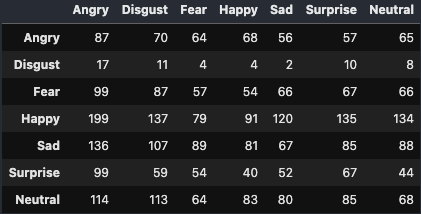<br>
4 слоя, 100 эпох (Epoch 00023: early stopping)<br>
Первый слой: 1024 узла, функция активации: relu; <br>
Второй слой: 512 узлов, функция активации: relu; <br>
Третий слой: 128 узлов, функция активации: relu; <br>
Четвертый слой: 7 узлов, функция активации: softmax <br>
***
<br>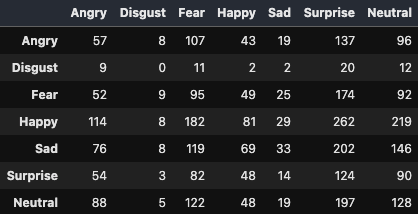<br>
4 слоя, 100 эпох (Epoch 00087: early stopping)<br>
Первый слой: 1024 узла, функция активации: selu; <br>
Второй слой: 512 узлов, функция активации: selu; <br>
Третий слой: 128 узлов, функция активации: selu; <br>
Четвертый слой: 7 узлов, функция активации: softmax <br>
***
<br>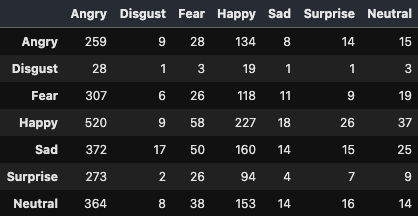<br>
5 слоев, 100 эпох (Epoch 00051: early stopping)<br>
Первый слой: 1024 узла, функция активации: elu; <br>
Второй слой: 1024 узла, функция активации: elu; <br>
Третий слой: 512 узлов, функция активации: elu; <br>
Четвертый слой: 256 узлов, функция активации: elu; <br>
Пятый слой: 7 узлов, функция активации: softmax <br>
***
<br>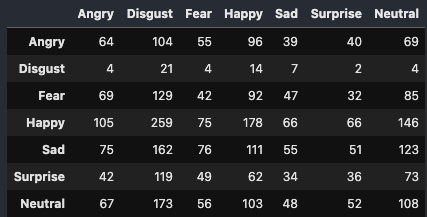<br>
7 слоев, 100 эпох (Epoch 00050: early stopping)<br>
Первый слой: 512 узлов, функция активации: selu; <br>
Второй слой: 256 узлов, функция активации: selu; <br>
Третий слой: 512 узлов, функция активации: relu; <br>
Четвертый слой: 256 узлов, функция активации: relu; <br>
Пятый слой: 512 узлов, функция активации: elu; <br>
Шестой слой: 256 узлов, функция активации: elu; <br>
Седьмой слой: 7 узлов, функция активации: softmax <br>
***

Изменение количества слоев влияет на количество возможных пройденных эпох. Так, чем больше мы используем слоев **Dense** в данной нейронной сети, тем меньше эпох обрабатывается. <br>Наиболее оптимальное количество нейронов в слоях **1024 + 512 + 128**. В таком случае, значение точности не уменьшается, а повышается. Но из-за ограничений в количестве слоев, проработать более 10 эпох не получилось. <br>
**Изменение видов функций активации:** используя ``sigmoid`` данные сильно сбиваются и потери очень велики, что приводит к ``overfitting``, поскольку у нас не бинарное количество данных. <br>
Также изменение параметра ``total_steps`` в оптимизаторе показало лучшие результаты при значении 100, чем при 10000. <br>

**1. Основная идея переноса обучения.** <br>
Использование предварительно обученных сетей для решения новых задач. <br>
**2. Каким образом учить все слои сети, а не только Dense?** <br>
Методом обратного распространения ошибки, но требуется минимум однократно непрерывно дифференцируемых нелинейных функций нейронов на всех слоях нейросети.